In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max

%matplotlib inline

## Question 1

In [2]:
def laplace_of_gaussian(sigma):
    hw = round(3*sigma)    # Half width of kernel
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))

    log = ((X**2 + Y**2)/(2*sigma**2) - 1) * np.exp(-(X**2 + Y**2)/(2*sigma**2)) / (np.pi * sigma**4)
    return log

In [3]:
def detect_max(img_log, sigma):
    coordinates = []
    (h, w) = img_log.shape
    k = 1
    for i in range(k, h-k):
        for j in range(k, w-k):
            slice_img = img_log[i-k:i+k+1, j-k:j+k+1]
            result = np.max(slice_img) # finding maximum
            if result >= 0.09: # threshold
                x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                coordinates.append((i+x-k, j+y-k)) #finding co-rdinates
    return set(coordinates)

(-27.425, 359.5, 359.5, -0.5)

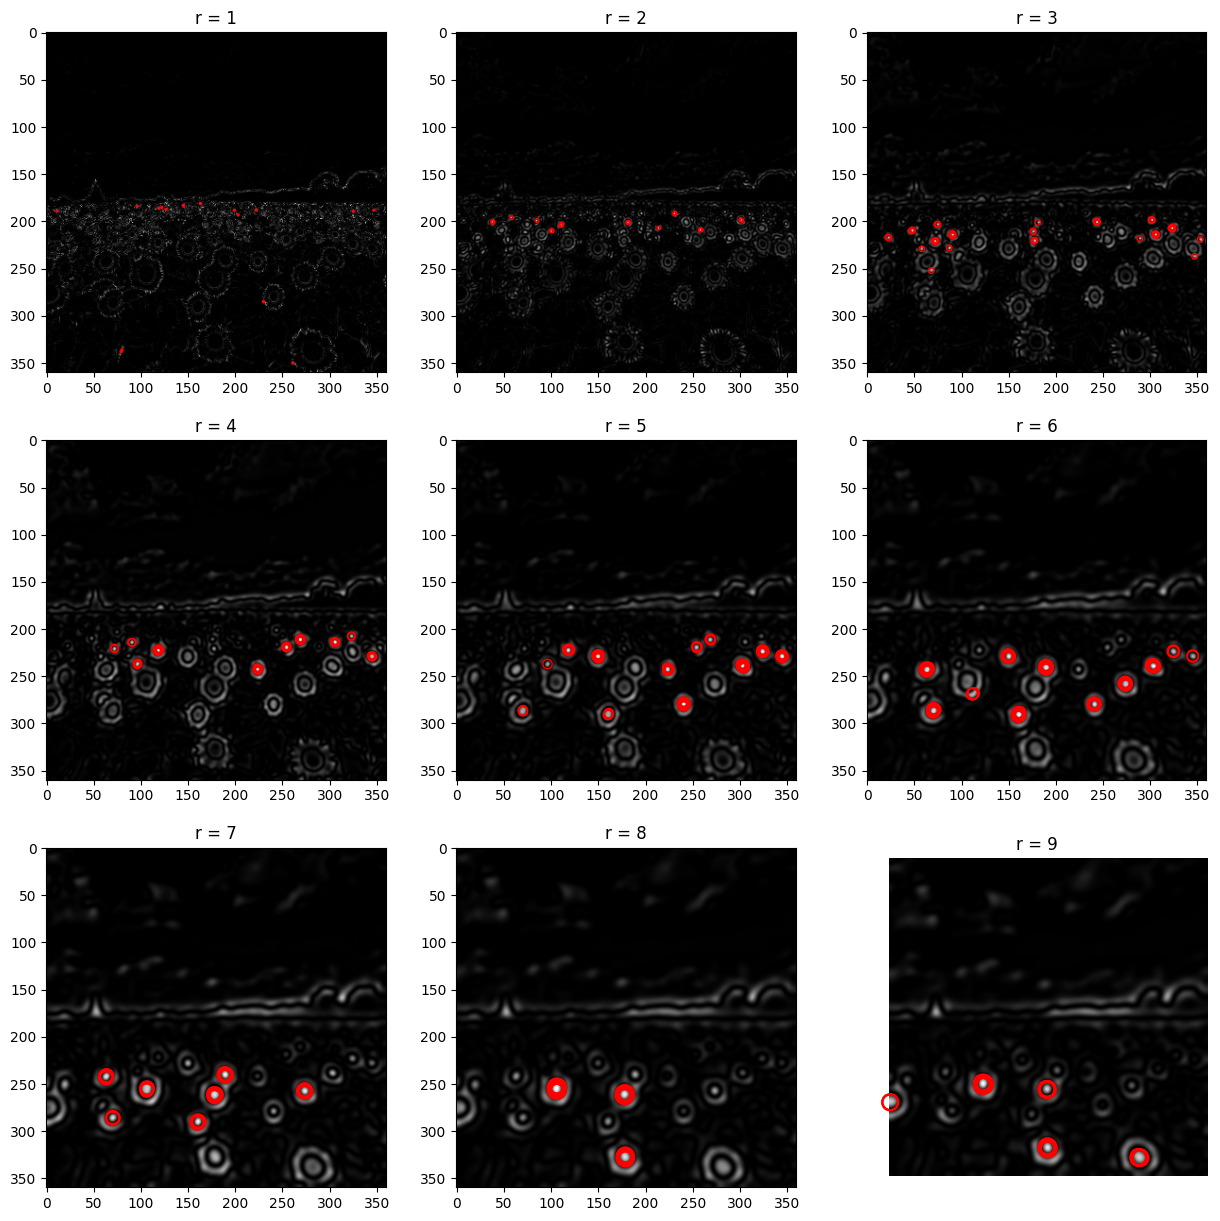

In [196]:
img1 = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255

fig, axes = plt.subplots(3, 3, figsize = (15, 15))

for r, ax in enumerate(axes.flatten(), start = 1):
    sigma = r/1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)
    img1_log = np.square(cv.filter2D(img1, -1, LOG))

    coordinates = detect_max(img1_log, sigma)

    ax.imshow(img1_log, cmap = 'gray')
    ax.set_title(f'r = {r}')

    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color = 'red', linewidth=1, fill=False)
        ax.add_patch(c)
    ax.plot()

plt.axis('off')

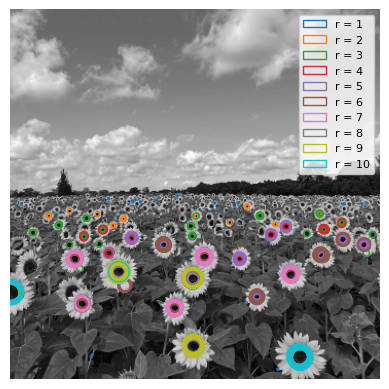

In [197]:
fig, ax = plt.subplots()
ax.imshow(img1, cmap = 'gray')
ax.grid(False)
colors = list(mcolors.TABLEAU_COLORS)

patches = []
labels = []

for r in range(1, 11):
    sigma = r/1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)
    img1_log = np.square(cv.filter2D(img1, -1, LOG))

    coordinates = detect_max(img1_log, sigma)

    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color = colors[r-1], linewidth=1, fill=False)
        ax.add_patch(c)
    patches.append(c)
    labels.append(f'r = {r}')
    ax.plot()
ax.set_xlim(0, img1.shape[1])

plt.axis('off')
ax.legend(patches, labels, loc='best', fontsize=8)


## Question 2

<AxesSubplot: >

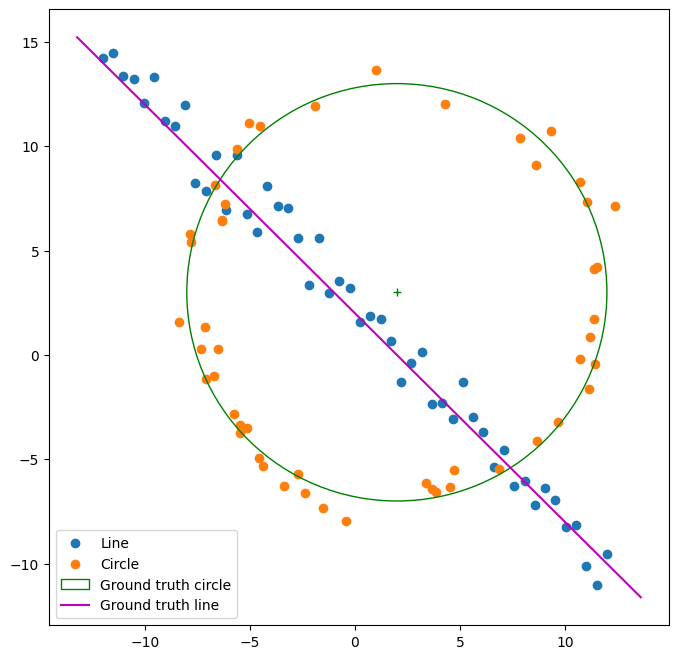

In [6]:
# Generating noisy point set

from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

# Set random seed
np.random.seed(0)

# Constants
N = 100
half_n = N // 2

# Parameters
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plotting
def plot_all():
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
    ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()


In [7]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def line_eq(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    a = (y2 - y1)
    b = -(x2 - x1)
    d = a*x1 + b*y1
    assert abs(a*x2 + b*y2 - d) < 1e-8

    # Apply constraint
    norm = (a**2 + b**2)**0.5
    a, b, d = a/norm, b/norm, d/norm
    return a, b, d

def circle_eq(p1, p2, p3):
    (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
    
    # circumcenter of circle is equidistant to all points
    mx1, my1 = (x1 + x2)/2, (y1 + y2)/2
    mx2, my2 = (x1 + x3)/2, (y1 + y3)/2

    s1 = -(x2 - x1)/(y2 - y1)
    s2 = -(x3 - x1)/(y3 - y1)

    c1 = my1 - s1 * mx1
    c2 = my2 - s2 * mx2

    cx = (c2 - c1)/(s1 - s2)
    cy = s1 * cx + c1
    assert abs(s2 * cx + c2 - cy) < 1e-8

    r = dist((cx, cy), p1)
    assert abs(dist((cx, cy), p2) - dist((cx, cy), p1)) < 1e-8
    return cx, cy, r
    

In [8]:
def tls_error_line(params, *args):
    # Error of points denoted by indices, params is the one that should be optimized
    a, b, d = params
    indices, X = args
    error = np.sum((a * X[indices, 0] + b * X[indices, 1] - d)**2)
    return error

def tls_error_circle(params, *args):
    cx, cy, r = params
    indices, X = args
    error = np.sum((dist((cx, cy), (X[indices, 0], X[indices, 1])) - r)**2)
    return error

In [9]:
def consensus_line(params, thres, X):   # Whether each point is an inlier
    a, b, d = params
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return np.where(errors < thres)

def consensus_circle(params, thres, X):   # Whether each point is an inlier
    cx, cy, r = params
    errors = np.abs(dist((cx, cy), (X[:, 0], X[:, 1])) - r) # radial error
    return np.where(errors < thres)

def constraint(params): # Should be equal to zero
    a, b, d = params
    return (a**2 + b**2)**0.5 - 1

constraint_dict = {'type':'eq', 'fun':constraint}

def least_squares_line_fit(indices, initial, X):  # line fitting with scipy minimize
    res = minimize(fun=tls_error_line, x0=initial, args=(indices, X), constraints=constraint_dict, tol=1e-6)
    print(res.x, res.fun)
    return res

def least_squares_circ_fit(indices, initial, X):
    res = minimize(fun=tls_error_circle, x0=initial, args=(indices, X), tol=1e-6)
    print(res.x, res.fun)
    return res

In [10]:
# Fitting the line

iters = 100
min_points = 2
N = X.shape[0]
np.random.seed(14)

thres = 1.   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_line = None
best_fitted_line = None
best_error = np.inf
best_line_inliers = None
best_line_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(0, N), size=min_points, replace=False)
    params = line_eq(X[indices[0]], X[indices[1]])
    inliers = consensus_line(params, thres, X)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:   # compute again 
        res = least_squares_line_fit(inliers, params, X)
        if res.fun < best_error:
            best_error = res.fun
            best_model_line = params
            best_fitted_line = res.x
            best_line_inliers = inliers
            best_sample_points = indices

line_inliers = consensus_line(best_fitted_line, 1.2, X)[0]

print(f'Best line = {best_fitted_line}, No. of inliers = {len(line_inliers)}, best_error = {best_error}')
    

Iteration 0: No. of inliers = 9
Iteration 1: No. of inliers = 34
Iteration 2: No. of inliers = 4
Iteration 3: No. of inliers = 16
Iteration 4: No. of inliers = 6
Iteration 5: No. of inliers = 12
Iteration 6: No. of inliers = 11
Iteration 7: No. of inliers = 8
Iteration 8: No. of inliers = 12
Iteration 9: No. of inliers = 15
Iteration 10: No. of inliers = 5
Iteration 11: No. of inliers = 8
Iteration 12: No. of inliers = 37
Iteration 13: No. of inliers = 12
Iteration 14: No. of inliers = 21
Iteration 15: No. of inliers = 8
Iteration 16: No. of inliers = 10
Iteration 17: No. of inliers = 16
Iteration 18: No. of inliers = 12
Iteration 19: No. of inliers = 23
Iteration 20: No. of inliers = 29
Iteration 21: No. of inliers = 6
Iteration 22: No. of inliers = 39
Iteration 23: No. of inliers = 38
Iteration 24: No. of inliers = 10
Iteration 25: No. of inliers = 4
Iteration 26: No. of inliers = 22
Iteration 27: No. of inliers = 40
[0.71205467 0.70212402 1.53281698] 8.09865025050975
Iteration 28: N

In [11]:
# fitting the circle

remaining_points = np.array([i for i in range(N) if i not in line_inliers])
X_rem = X[remaining_points]

iters = 100
min_points = 3  # We need 3 points to estimate a circle

thres = 1.2   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_circle = None
best_fitted_circle = None
best_error = np.inf
best_circ_inliers = None
best_circ_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(len(X_rem)), size=min_points, replace=False)
    params = circle_eq(*X_rem[indices])
    inliers = consensus_circle(params, thres, X_rem)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:   # compute again 
        res = least_squares_circ_fit(inliers, params, X_rem)
        if res.fun < best_error:
            best_error = res.fun
            best_model_circle = params
            best_fitted_circle = res.x
            best_circ_inliers = inliers
            best_circ_sample_points = indices

circ_inliers = consensus_circle(best_fitted_circle, thres, X_rem)[0]

print(f'Best circle = {best_fitted_circle}, No. of inliers = {len(circ_inliers)}, best_error = {best_error}')

Iteration 0: No. of inliers = 10
Iteration 1: No. of inliers = 12
Iteration 2: No. of inliers = 10
Iteration 3: No. of inliers = 41
[1.8828232  3.18299016 9.81978826] 8.709305494445344
Iteration 4: No. of inliers = 34
Iteration 5: No. of inliers = 5
Iteration 6: No. of inliers = 25
Iteration 7: No. of inliers = 21
Iteration 8: No. of inliers = 30
Iteration 9: No. of inliers = 41
[1.69665199 3.00402845 9.92790141] 9.203751651287867
Iteration 10: No. of inliers = 37
Iteration 11: No. of inliers = 17
Iteration 12: No. of inliers = 25
Iteration 13: No. of inliers = 35
Iteration 14: No. of inliers = 11
Iteration 15: No. of inliers = 44
[1.81818057 3.07505684 9.97826825] 12.835201704007074
Iteration 16: No. of inliers = 8
Iteration 17: No. of inliers = 18
Iteration 18: No. of inliers = 39
Iteration 19: No. of inliers = 28
Iteration 20: No. of inliers = 14
Iteration 21: No. of inliers = 10
Iteration 22: No. of inliers = 34
Iteration 23: No. of inliers = 28
Iteration 24: No. of inliers = 41
[1

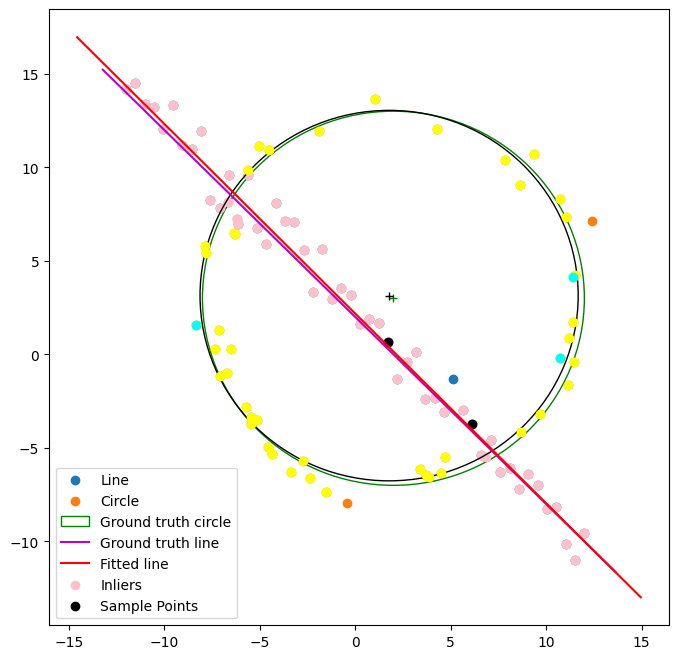

In [12]:
ax = plot_all()

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
A, B, D = best_fitted_line
indices = line_inliers

y_ = (D - A*x_) / B
plt.plot(x_, y_, color='r', label='Fitted line')
ax.scatter(X[indices, 0], X[indices, 1], color = 'pink', label = "Inliers")
ax.scatter(X[best_sample_points, 0], X[best_sample_points, 1], color = 'black', label = "Sample Points")
plt.legend()

x0, y0, r0 = best_fitted_circle
circle_gt = plt.Circle((x0, y0), r0, color='black', fill=False, label='RANSAC circle')
ax.add_patch(circle_gt)
ax.plot(x0, y0, '+', color='black')

ax.scatter(X_rem[circ_inliers, 0], X_rem[circ_inliers, 1], color = 'yellow', label = "Circle Inliers")
ax.scatter(X_rem[best_circ_sample_points, 0], X_rem[best_circ_sample_points, 1], color = 'cyan', label = "Sample Points")

## Question 3

(-0.5, 274.5, 182.5, -0.5)

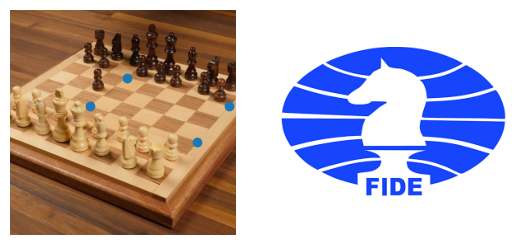

In [13]:
from skimage import transform

img3 = cv.imread("images/chess.png")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

logo = cv.imread("images/fide2.png")
logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB)

dst_points = [(423, 514), (994, 703), (1163, 514), (620, 363)]
dst_points = np.array([np.array(p) for p in dst_points])

plt.subplot(1, 2, 1)
plt.imshow(img3)
plt.scatter(dst_points[:, 0], dst_points[:, 1])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(logo)
plt.axis('off')


In [14]:
def superimpose(image, logo, dst_points, beta = 0.3, alpha = 1):
    
    y, x, _ = logo.shape
    src_points = [(0, y), (x, y), (x, 0), (0, 0)]   # bl, br, tr, tl
    src_points = np.array([np.array(p) for p in src_points])

    if logo.shape[0] <= img3.shape[0]:
        logo = np.pad(logo, ((0, img3.shape[0] - logo.shape[0]), (0, 0), (0, 0)), 'constant')

    if logo.shape[1] <= img3.shape[1]:
        logo = np.pad(logo, ((0, 0), (0, img3.shape[1] - logo.shape[1]), (0, 0)), 'constant')

    tform = transform.estimate_transform('projective', src_points, dst_points)
    tf_img = transform.warp(logo, tform.inverse)
    tf_img = (tf_img * 255).astype(np.uint8)

    if logo.shape[0] > img3.shape[0]:
        tf_img = tf_img[:img3.shape[0]]

    if logo.shape[1] > img3.shape[1]:
        tf_img = tf_img[:, :img3.shape[1]]

    dst = cv.addWeighted(img3, alpha, tf_img, beta, 0)
    return dst

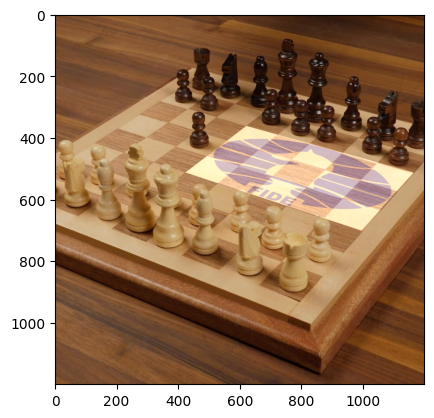

In [15]:
dst = superimpose(img3, logo, dst_points, 0.3, 0.9)
plt.imshow(dst)

(-0.5, 1469.5, 979.5, -0.5)

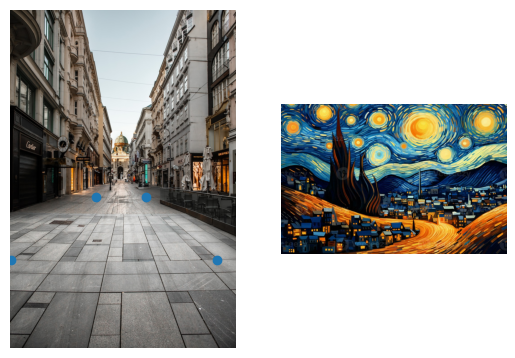

In [16]:
img3 = cv.imread("images/street.jfif")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

logo = cv.imread("images/starrynight.jpg")
logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB) 

dst_points = [(919, 1109), (604, 831), (379, 831), (3, 1109)]
dst_points = np.array([np.array(p) for p in dst_points])

plt.subplot(1, 2, 1)
plt.imshow(img3)
plt.scatter(dst_points[:, 0], dst_points[:, 1])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(logo)
plt.axis('off')

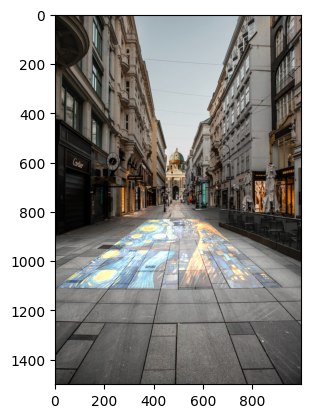

In [17]:
dst = superimpose(img3, logo, dst_points, 0.6, 0.9)
plt.imshow(dst)

## Question 4

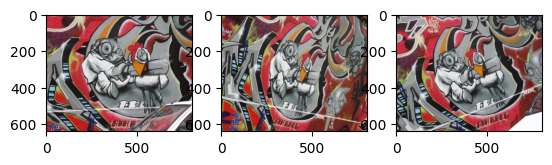

In [132]:
img1 = cv.imread("images/graf/img1.ppm")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img3 = cv.imread("images/graf/img3.ppm")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

img5 = cv.imread("images/graf/img2.ppm")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

plt.subplot(1, 3, 1)
plt.imshow(img1)

plt.subplot(1, 3, 2)
plt.imshow(img3)

plt.subplot(1, 3, 3)
plt.imshow(img5)

In [142]:
def SIFT_features(img1, img5):
    # Feature matching with SIFT
    img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    img5_gray = cv.cvtColor(img5, cv.COLOR_RGB2GRAY)

    # Identify key points of each image
    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1) 

    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors5, k=2)  # Find k best matches
    # Apply ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append(m)

    #matched_img = cv.drawMatches(img1_gray, keypoints1, img5_gray, keypoints5, good_matches[50:], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #plt.imshow(matched_img)

    return good_matches, keypoints1, keypoints5

In [143]:
def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum(np.square(dst_check - dst_full), axis = 1))

    return np.where(errors < thres)[0]

In [152]:
def find_best_homography(good_matches, keypoints1, keypoints5):
    # Array of all the matching points
    src_full = []
    dst_full = []

    for match in good_matches:
        src_full.append(np.array(keypoints1[match.queryIdx].pt))
        dst_full.append(np.array(keypoints5[match.trainIdx].pt))

    src_full = np.array(src_full)
    dst_full = np.array(dst_full)

    # RANSAC for finding best homography
    num_points = 4
    thres = 1
    d = 0.5 * len(good_matches)
    iters = 200

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace = False)

        src_points = []
        dst_points = []
        for match in chosen_matches:
            src_points.append(np.array(keypoints1[match.queryIdx].pt))
            dst_points.append(np.array(keypoints5[match.trainIdx].pt))

        src_points = np.array(src_points)
        dst_points = np.array(dst_points)

        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, thres)
        #print(f'Iteration {i}: No. of inliers = {len(inliers)}')

        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best no. of inliers = {best_inlier_count}')
    return best_homography, best_inliers

Best no. of inliers = 734
Best no. of inliers = 544
Best no. of inliers = 695
Best no. of inliers = 493


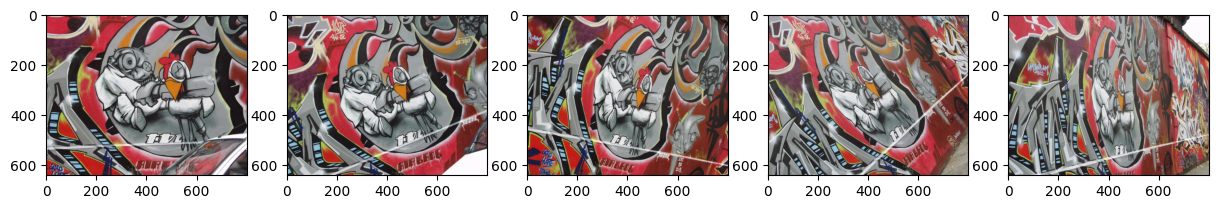

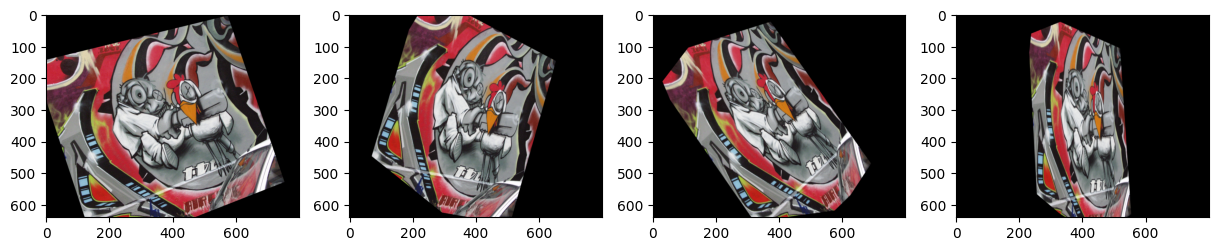

In [201]:
np.random.seed(62)
pad = 100

images = []
plt.figure(figsize = (15, 10))
for i in range(1, 6):
    img = cv.imread(f"images/graf/img{i}.ppm")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(1, 5, i)
    plt.imshow(img)

transforms = []
final_transformed_image = images[0]
#final_transformed_image = np.pad(final_transformed_image, ((0, pad), (0, pad), (0, 0)), 'constant')

plt.figure(figsize = (15, 10))
for i in range(1, 5):
    img1, img2 = images[i-1], images[i]
    good_matches, keypoints1, keypoints5 = SIFT_features(img1, img2)
    tform, _ = find_best_homography(good_matches, keypoints1, keypoints5)
    final_transformed_image = transform.warp(final_transformed_image, tform.inverse)
    plt.subplot(1, 4, i)
    plt.imshow(final_transformed_image)

final_transformed_image = (final_transformed_image * 255).astype(np.uint8)

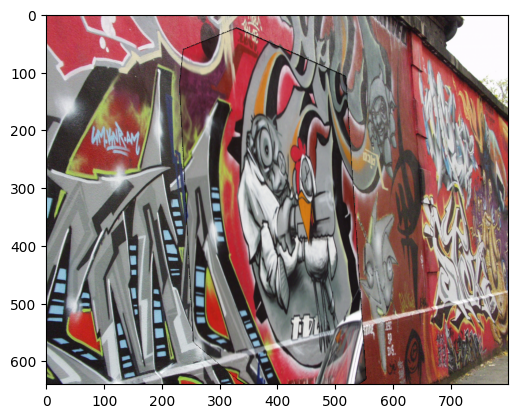

In [208]:
mask = (final_transformed_image == 0)
stitched_image = mask * images[4] + final_transformed_image
plt.imshow(stitched_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


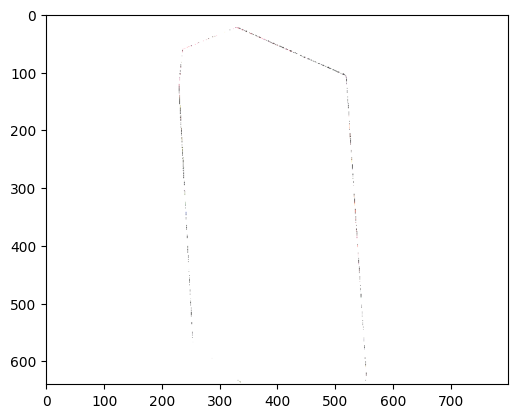

In [175]:
plt.imshow(mask * images[4] + final_transformed_image)

In [176]:
stitched_image

array([[[182.,  61.,  60.],
        [183.,  61.,  61.],
        [191.,  68.,  70.],
        ...,
        [253., 252., 254.],
        [254., 252., 254.],
        [253., 252., 254.]],

       [[189.,  63.,  74.],
        [186.,  60.,  71.],
        [186.,  60.,  72.],
        ...,
        [254., 252., 254.],
        [254., 252., 254.],
        [254., 252., 254.]],

       [[190.,  59.,  78.],
        [190.,  60.,  78.],
        [184.,  57.,  72.],
        ...,
        [254., 252., 254.],
        [254., 252., 255.],
        [254., 252., 254.]],

       ...,

       [[ 29.,  30.,  33.],
        [ 28.,  27.,  33.],
        [ 31.,  28.,  38.],
        ...,
        [158., 155., 139.],
        [157., 153., 139.],
        [156., 152., 138.]],

       [[ 32.,  31.,  34.],
        [ 28.,  27.,  31.],
        [ 29.,  29.,  32.],
        ...,
        [163., 159., 148.],
        [162., 158., 148.],
        [166., 162., 152.]],

       [[ 32.,  30.,  23.],
        [ 31.,  31.,  24.],
        [ 31.,  

In [104]:
tform(src_points)

array([[274.96673584, 455.14099121],
       [274.96673584, 455.14099121],
       [459.21064302, 612.47006652],
       [274.96673584, 455.14099121]])

In [102]:
tform

<ProjectiveTransform(matrix=
    [[ 1.89911697e+00, -3.13767773e+00,  2.74966736e+02],
     [ 3.14352926e+00, -5.19366733e+00,  4.55140991e+02],
     [ 6.90671532e-03, -1.14111175e-02,  1.00000000e+00]]) at 0x213672bca50>

In [103]:
src_points, dst_points

(array([[760.0020752 , 550.54431152],
        [753.97723389, 556.49755859],
        [442.5552063 , 355.4956665 ],
        [772.08569336, 539.01739502]]),
 array([[274.96673584, 455.14099121],
        [274.96673584, 455.14099121],
        [458.26211548, 610.94830322],
        [274.96673584, 455.14099121]]))